https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

#### **Cargamos librerías y definimos configuación general**

In [1]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import torchvision

import matplotlib.pyplot as plt

%matplotlib inline

from auxiliary import *

In [2]:
def train(epochs, load_checkpoint=False, save_checkpoint=True, verbose=False):
    
    prev_epoch = 0
    if load_checkpoint:
        if verbose:
            print('Loading parameters...')
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        train_loss_values = checkpoint['train_loss']
        test_loss_values = checkpoint['test_loss']
    else:
        train_loss_values = np.array([])
        test_loss_values = np.array([])
        
    last_epoch = prev_epoch + epochs
    for epoch in range(prev_epoch + 1, last_epoch + 1):
        loss = 0
        for batch_features, _ in train_loader:

            # load it to the active device
            batch_features = batch_features.to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(batch_features)

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        avg_train_loss = loss / len(train_loader)
        train_loss_values = np.append(train_loss_values, avg_train_loss)

        with torch.no_grad():
            loss = 0
            for batch_features, _ in test_loader:

                # load it to the active device
                batch_features = batch_features.to(device)

                # compute reconstructions
                outputs = model(batch_features)

                # compute testing reconstruction loss
                test_loss = criterion(outputs, batch_features)

                # add the mini-batch testing loss to epoch loss
                loss += test_loss.item()

        # compute the epoch testing loss
        avg_test_loss = loss / len(test_loader)

        test_loss_values = np.append(test_loss_values, avg_test_loss)

        if verbose:
            # display the epoch training loss
            print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}, ".format(
                epoch, last_epoch, avg_train_loss, avg_test_loss)
            )
    if save_checkpoint:
        params = {
            'epoch': last_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss_values,
            'test_loss': test_loss_values
        }
        torch.save(params, model_path)

    return train_loss_values, test_loss_values

In [3]:
class Flatten(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), -1)

class Squeeze(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), 1, 28, 28)

class CAE(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.relu(x)
        x = self.linear2(x)
        return x

#### **Definimos hiperparámetros del modelo**

In [4]:
## Dataset parameters
input_shape = 28*28

## Model parameters
p_dropout = 0.1
hidden_layer_size = 64

## Optimizer parameters
optimizer_name = 'SGD'
train_batch_size = 1000
test_batch_size = 1000
learning_rate = 10
momentum = 0.5

#### **Cargamos los datos**

In [5]:
datasets, loaders = load_data(train_batch_size, test_batch_size)
train_dataset, test_dataset = datasets
train_loader, test_loader = loaders

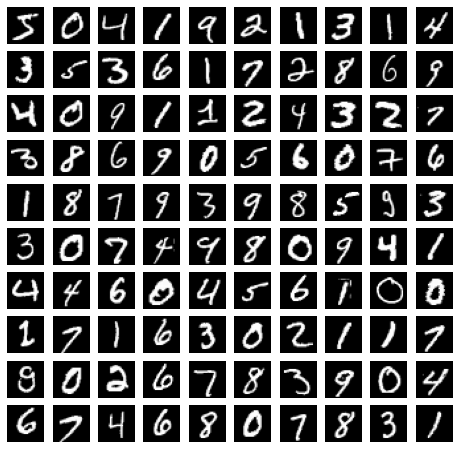

In [6]:
output = os.path.join(fig_dir, 'ejemplos.pdf')
plot_examples(train_dataset, (10,10), output)

In [9]:
base_model_name = create_base_model_name('Linear',
    optimizer_name, hidden_layer_size, p_dropout, 
    train_batch_size, learning_rate, momentum
)
print(base_model_name)
model_name = base_model_name + '.pt'
model_path = os.path.join(model_dir, model_name)

Linear_SGD_hidden0064_dropout0.100_batch01000_lr10.000000_momentum0.500000


#### **Defino el modelo**

In [10]:
## Inicializo modelo
model = AE(
    input_shape=input_shape,
    hidden_layer_size=hidden_layer_size,
    p_dropout=p_dropout
)

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
else:
    raise

# mean-squared error loss
criterion = nn.MSELoss()

## uso gpu si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
model.to(device)

overwrite = False
load_checkpoint = os.path.isfile(model_path) & (~overwrite)
    
epochs = 2
train_loss_values, test_loss_values = train(
    epochs, load_checkpoint=load_checkpoint, verbose=True
)    

Device: cpu
Loading parameters...
epoch : 21/22, train loss = 0.025489, test loss = 0.025068, 
epoch : 22/22, train loss = 0.025416, test loss = 0.024937, 


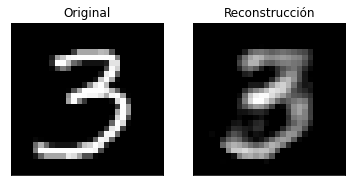

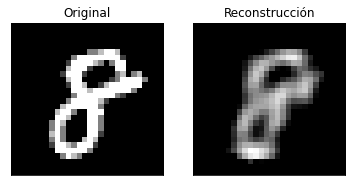

In [8]:
def compare(dataset, n=None):

    if not n:
        n = np.random.randint(dataset.data.size(0))
    inpt = dataset[n][0]

    original = inpt.detach().numpy().squeeze()
    autoencoded = model(inpt).detach().numpy().squeeze()

    titles = ['Original', 'Reconstrucción']

    fig, axes = plt.subplots(ncols=2)

    for i, img in enumerate([original, autoencoded]):
        ax = axes[i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        ax.imshow(img, cmap='gray')

compare(train_dataset)
compare(test_dataset)

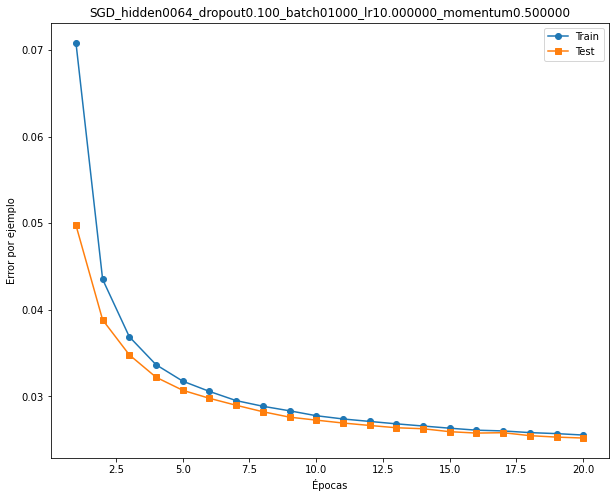

In [9]:
X = np.arange(1, len(train_loss_values)+1)

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title(base_model_name)

ax.set_ylabel('Error por ejemplo')
ax.set_xlabel('Épocas')

ax.plot(X, np.array(train_loss_values), 'o-', label='Train')
ax.plot(X, np.array(test_loss_values), 's-', label='Test')

ax.legend()

plt.savefig(os.path.join(fig_dir, base_model_name + '.png'))
plt.show()

In [12]:
train_loss_dict = {}
test_loss_dict = {}

hidden_values = [64, 128, 256, 512]

for hidden in hidden_values:
    base_model_name = create_base_model_name(
        optimizer_name, hidden, p_dropout, 
        train_batch_size, learning_rate, momentum
    )
    model_path = os.path.join(model_dir, base_model_name + '.pt')
    checkpoint = torch.load(model_path)
    train_loss_values = checkpoint['train_loss']
    test_loss_values = checkpoint['test_loss']

    train_loss_dict[hidden] = train_loss_values
    test_loss_dict[hidden] = test_loss_values

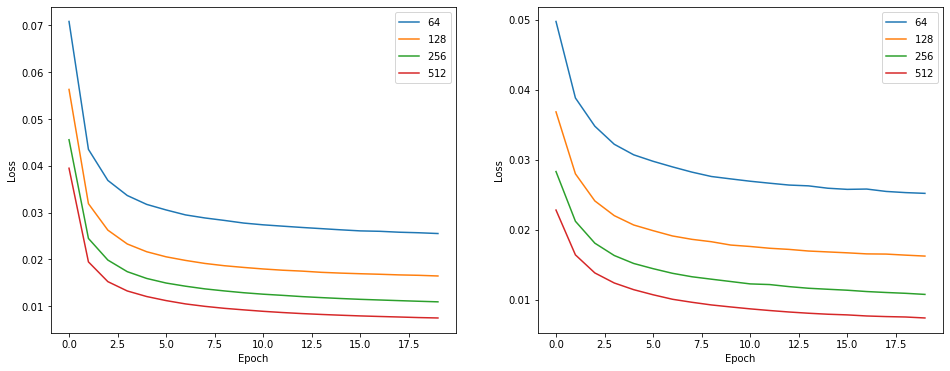

In [13]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for hidden in hidden_values:
    train_loss, test_loss = train_loss_dict[hidden], test_loss_dict[hidden]
    for i, loss_values in enumerate([train_loss, test_loss]):
        ax = axes[i]
        X = np.arange(train_loss.shape[0])
        ax.plot(X, loss_values, label=r'${{{}}}$'.format(hidden))

for ax in axes:
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()